In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gpd
from tqdm import tqdm
tqdm.pandas()
from shapely.geometry import Point
from sklearn.neighbors import NearestNeighbors

In [19]:
def crossref(df, gdf):
    shapes = gdf.geometry
    centroids = [x.centroid for x in shapes]
    centroids = np.array([(x.x, x.y) for x in centroids])
    nn = NearestNeighbors(n_neighbors=3, algorithm='ball_tree').fit(centroids)
    _, indices = nn.kneighbors(df[['LONGITUDE', 'LATITUDE']])

    id_poly = []
    i = 0
    for _, row in tqdm(df.iterrows(), total=len(df)):
        point = Point(row['LONGITUDE'], row['LATITUDE'])
        new_id = None
        for idx in indices[i]:
            if shapes[idx].contains(point):
                new_id = idx
                break
        id_poly.append(new_id)
        i += 1

    df['id_poly'] = id_poly
    return df
    

In [3]:
def groupby_month(df):
    df["year"] = df.date.dt.year
    df["month"] = df.date.dt.month
    df = df.groupby(["id_poly", "year", "month"]).size().reset_index()
    df.columns = ["id_poly", "year", "month", "count"]
    df["id_poly"] = df["id_poly"].astype(int)
    return df

def transform_month_to_ts(df):
    start_year = df.year.min()
    start_month = df[df.year == start_year].month.min()
    end_year = df.year.max()
    end_month = df[df.year == end_year].month.max()
    n_months = (end_year - start_year) * 12 + end_month - start_month + 1

    id_poly = df.id_poly
    n_poly = id_poly.max() + 1

    ts = np.zeros((n_poly, n_months))
    k = 0
    for m in range(start_month, 13):
        filtered = df[(df.year == start_year) & (df.month == m)]
        if len(filtered) == ts.shape[0]:
            ts[:, k] = filtered["count"]
        elif len(filtered) > 0:
            ts[filtered.id_poly, k] = filtered["count"]
        k += 1

    for y in range(start_year + 1, end_year):
        for m in range(1, 13):
            filtered = df[(df.year == y) & (df.month == m)]
            if len(filtered) == ts.shape[0]:
                ts[:, k] = filtered["count"]
            elif len(filtered) > 0:
                ts[filtered.id_poly, k] = filtered["count"]
            k += 1

    for m in range(1, end_month + 1):
        filtered = df[(df.year == end_year) & (df.month == m)]
        if len(filtered) == ts.shape[0]:
            ts[:, k] = filtered["count"]
        elif len(filtered) > 0:
            ts[filtered.id_poly, k] = filtered["count"]
        k += 1
        
    return ts


def groupby_day(df):
    day_ns = 60*60*24*10**9
    df["date_int"] = df.date.astype(int)
    df["date_int"] = df.date_int / day_ns
    df["date_int"] = df.date_int.astype(int)    
    df = df.groupby(["id_poly", "date_int"]).size().reset_index()
    df.columns = ["id_poly", "date_int", "count"]
    df["id_poly"] = df["id_poly"].astype(int)
    df = df.sort_values(["id_poly", "date_int"])
    return df


def transform_day_to_ts(df):
    min_date = df.date_int.min()
    max_date = df.date_int.max()
    n_days = max_date - min_date + 1
    id_poly = df.id_poly
    n_poly = id_poly.max() + 1
    ts = np.zeros((n_poly, n_days))
    k = 0
    for day in range(min_date, max_date + 1):
        filtered = df[df.date_int == day]
        if len(filtered) == ts.shape[0]:
            ts[:, k] = filtered["count"]
        else:
        # fill missing values with 0
            ts[:, k] = 0
            ts[filtered.id_poly, k] = filtered["count"]
        k += 1

    return ts


## Climate

https://basedosdados.org/dataset/782c5607-9f69-4e12-b0d5-aa0f1a7a94e2?table=28d16282-d100-4ea8-9dde-36c05c8f1ca2

In [2]:
df = pd.read_csv("data/estacao.csv")
print(df.shape)

(612, 7)


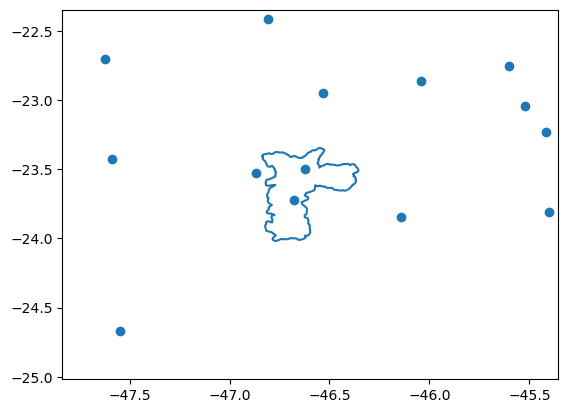

In [14]:
# read geojson
gdf = gpd.read_file("data/countour.geojson")
# get bbox
bbox = gdf.total_bounds
plt.scatter(df['longitude'], df['latitude'])
plt.xlim(bbox[0] - 1, bbox[2] + 1)
plt.ylim(bbox[1] - 1, bbox[3] + 1)
plt.plot(gdf.geometry[0].exterior.xy[0], gdf.geometry[0].exterior.xy[1])
plt.show()


## Waze

In [4]:
N = 100000
df = pd.read_csv("data/time_series/waze-alerts.csv")
df = df.sample(N)
print(df.shape)
df.columns

(100000, 6)


Index(['geo', 'ts', ' type', ' subtype', ' reliability', ' confidence'], dtype='object')

In [5]:
df["date"] = pd.to_datetime(df["ts"])
df["LONGITUDE"] = df["geo"].apply(lambda x : x.split("(")[1].split(" ")[0])
df["LATITUDE"] = df["geo"].apply(lambda x : x.split(" ")[1].split(")")[0])
df.LONGITUDE = df.LONGITUDE.astype(float)
df.LATITUDE = df.LATITUDE.astype(float)

In [6]:
df[" type"].value_counts()

 type
JAM              71595
WEATHERHAZARD    22368
ACCIDENT          2936
HAZARD            2194
ROAD_CLOSED        907
Name: count, dtype: int64

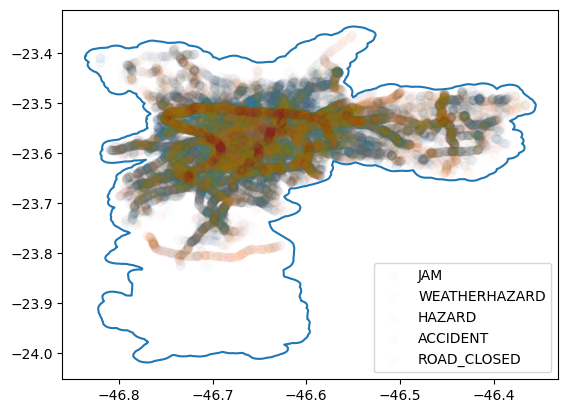

In [7]:
countour = gpd.read_file("data/countour.geojson")
plt.plot(countour.geometry[0].exterior.xy[0], countour.geometry[0].exterior.xy[1])
for ty in df[" type"].unique():
    df_filter = df[df[" type"] == ty]
    plt.scatter(df_filter['LONGITUDE'], df_filter['LATITUDE'], alpha = 0.01, label = ty)
plt.legend()
plt.show()

### District

In [20]:
gdf = gpd.read_file("data/shapefiles/SpDistricts.shp")
df = crossref(df, gdf)
df.to_csv("data/geo_data/WazeAlerts_SpDistricts.csv", index = False)

/home/giovani/anaconda3/envs/wavelet_code/lib/python3.10/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but NearestNeighbors was fitted without feature names
  warnings.warn(
100%|██████████| 100000/100000 [00:16<00:00, 5921.53it/s]


In [21]:
df = pd.read_csv("data/geo_data/WazeAlerts_SpDistricts.csv")
df["date"] = pd.to_datetime(df["date"])
df = df[df.date < "2024-01-01"]
df = df[df.date >= "2019-04-01"]
df = df.dropna(subset = ["id_poly"])

In [22]:
df_month = groupby_month(df)
ts_month = transform_month_to_ts(df_month)
np.save("data/time_series/WazeAlerts_SpDistricts_Month.npy", ts_month)

In [23]:
df = df[df.date < "2020-01-01"]
df_day = groupby_day(df)
ts_day = transform_day_to_ts(df_day)
np.save("data/time_series/WazeAlerts_SpDistricts_Day.npy", ts_day)

### Center census

In [ ]:
gdf = gpd.read_file("data/shapefiles/SpCenterCensus10k.shp")
df = crossref(df, gdf)
df.to_csv("data/geo_data/WazeAlerts_SpCenterCensus10k.csv", index = False)

In [ ]:
df = pd.read_csv("data/geo_data/waze_alerts_sp_center_census.csv")
df["date"] = pd.to_datetime(df["date"])
df = df[df.date < "2024-01-01"]
df = df[df.date >= "2019-04-01"]
df = df.dropna(subset = ["id_poly"])

In [ ]:
df_month = groupby_month(df)
ts_month = transform_month_to_ts(df_month)
np.save("data/time_series/waze_alerts_sp_center_census_month.npy", ts_month)

In [ ]:
df = df[df.date < "2020-01-01"]
df_day = groupby_day(df)
ts_day = transform_day_to_ts(df_day)
np.save("data/time_series/waze_alerts_sp_center_census_day.npy", ts_day)

## Crime theft

In [24]:
df = pd.read_csv("data/time_series/furto_celular_2018_2022.csv", sep = ";")
# drop columns with more than 0.1 of missing values
df["date"] = pd.to_datetime(df.DATAOCORRENCIA, format='%d/%m/%Y', errors='coerce')
df = df.dropna(thresh=0.9*len(df), axis=1)
df = df.dropna()
df = df.drop(columns = ["ANO_BO", "DATAOCORRENCIA"], axis = 1)
df = df[df.date > "2018-01-01"]
df = df.reset_index(drop=True)
df.shape

/tmp/ipykernel_90722/2216112243.py:1: DtypeWarning: Columns (17) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("data/time_series/furto_celular_2018_2022.csv", sep = ";")


(389397, 13)

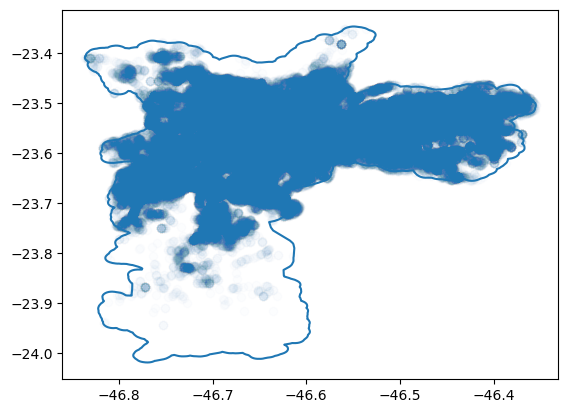

In [19]:
countour = gpd.read_file("data/countour.geojson")
plt.plot(countour.geometry[0].exterior.xy[0], countour.geometry[0].exterior.xy[1])
plt.scatter(df['LONGITUDE'], df['LATITUDE'], alpha = 0.01)
plt.show()

### District

In [25]:
gdf = gpd.read_file("data/shapefiles/SpDistricts.shp")
df = crossref(df, gdf)
df.to_csv("data/geo_data/FurtoCelular_SpDistricts.csv", index = False)

/home/giovani/anaconda3/envs/wavelet_code/lib/python3.10/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but NearestNeighbors was fitted without feature names
  warnings.warn(
100%|██████████| 389397/389397 [01:05<00:00, 5905.33it/s]


In [26]:
df = pd.read_csv("data/geo_data/FurtoCelular_SpDistricts.csv")
df["date"] = pd.to_datetime(df["date"])
df = df[df.date < "2024-01-01"]
df = df[df.date >= "2019-04-01"]
df = df.dropna(subset = ["id_poly"])

In [27]:
df_month = groupby_month(df)
ts_month = transform_month_to_ts(df_month)
np.save("data/time_series/FurtoCelular_SpDistricts_Month.npy", ts_month)

In [28]:
df = df[df.date < "2020-01-01"]
df_day = groupby_day(df)
ts_day = transform_day_to_ts(df_day)
np.save("data/time_series/FurtoCelular_SpDistricts_Day.npy", ts_day)

### Center census

In [21]:
gdf = gpd.read_file("data/shapefiles/sp_center_census.shp")
df = crossref(df, gdf)
df.to_csv("data/geo_data/crime_sp_center_census.csv", index = False)

100%|██████████| 389397/389397 [7:31:46<00:00, 14.37it/s]   


In [9]:
df = pd.read_csv("data/geo_data/crime_sp_center_census.csv")
df["date"] = pd.to_datetime(df["date"])
df = df[df.date < "2024-01-01"]
df = df[df.date >= "2019-04-01"]
df = df.dropna(subset = ["id_poly"])

In [10]:
df_month = groupby_month(df)
ts_month = transform_month_to_ts(df_month)
np.save("data/time_series/crime_sp_center_census_month.npy", ts_month)

In [11]:
df = df[df.date < "2020-01-01"]
df_day = groupby_day(df)
ts_day = transform_day_to_ts(df_day)
np.save("data/time_series/crime_sp_center_census_day.npy", ts_day)

## Crime robbery

In [29]:
df = pd.read_csv("data/time_series/roubo_celular_2018_2022.csv", sep = ";")
# drop columns with more than 0.1 of missing values
df["date"] = pd.to_datetime(df.DATAOCORRENCIA, format='%d/%m/%Y', errors='coerce')
df = df.dropna(thresh=0.9*len(df), axis=1)
df = df.dropna()
df = df.drop(columns = ["ANO_BO", "DATAOCORRENCIA"], axis = 1)
df = df[df.date > "2018-01-01"]
df = df.reset_index(drop=True)
df.shape

/tmp/ipykernel_90722/1213486941.py:1: DtypeWarning: Columns (17) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("data/time_series/roubo_celular_2018_2022.csv", sep = ";")


(588122, 14)

### District

In [30]:
gdf = gpd.read_file("data/shapefiles/SpDistricts.shp")
df = crossref(df, gdf)
df.to_csv("data/geo_data/RouboCelular_SpDistricts.csv", index = False)

/home/giovani/anaconda3/envs/wavelet_code/lib/python3.10/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but NearestNeighbors was fitted without feature names
  warnings.warn(
100%|██████████| 588122/588122 [01:58<00:00, 4949.40it/s]


In [31]:
df = pd.read_csv("data/geo_data/RouboCelular_SpDistricts.csv")
df["date"] = pd.to_datetime(df["date"])
df = df[df.date < "2024-01-01"]
df = df[df.date >= "2019-04-01"]
df = df.dropna(subset = ["id_poly"])

In [32]:
df_month = groupby_month(df)
ts_month = transform_month_to_ts(df_month)
np.save("data/time_series/RouboCelular_SpDistricts_Month.npy", ts_month)

In [33]:
df = df[df.date < "2020-01-01"]
df_day = groupby_day(df)
ts_day = transform_day_to_ts(df_day)
np.save("data/time_series/RouboCelular_SpDistricts_Day.npy", ts_day)

### Center census

In [ ]:
gdf = gpd.read_file("data/shapefiles/sp_center_census.shp")
df = crossref(df, gdf)
df.to_csv("data/geo_data/roubo_celular_sp_center_census.csv", index = False)

In [ ]:
df = pd.read_csv("data/geo_data/roubo_celular_sp_center_census.csv")
df["date"] = pd.to_datetime(df["date"])
df = df[df.date < "2024-01-01"]
df = df[df.date >= "2019-04-01"]
df = df.dropna(subset = ["id_poly"])

In [ ]:
df_month = groupby_month(df)
ts_month = transform_month_to_ts(df_month)
np.save("data/time_series/roubo_celular_sp_center_census_month.npy", ts_month)

In [ ]:
df = df[df.date < "2020-01-01"]
df_day = groupby_day(df)
ts_day = transform_day_to_ts(df_day)
np.save("data/time_series/roubo_celular_sp_center_census_day.npy", ts_day)